In [6]:
import numpy as np 
import pandas as pd
import pickle

In [7]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [8]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
df=pd.read_csv('Crop_recommendation.csv')
df.head()

,N,P,K,temperature,humidity,ph,rainfall,label
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice


In [10]:
df.describe()

,N,P,K,temperature,humidity,ph,rainfall
count,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000
mean,50.551818,53.362727,48.149091,25.616244,71.481779,6.469480,103.463655
std,36.917334,32.985883,50.647931,5.063749,22.263812,0.773938,54.958389
min,0.000000,5.000000,5.000000,8.825675,14.258040,3.504752,20.211267
25%,21.000000,28.000000,20.000000,22.769375,60.261953,5.971693,64.551686
50%,37.000000,51.000000,32.000000,25.598693,80.473146,6.425045,94.867624
75%,84.250000,68.000000,49.000000,28.561654,89.948771,6.923643,124.267508
max,140.000000,145.000000,205.000000,43.675493,99.981876,9.935091,298.560117


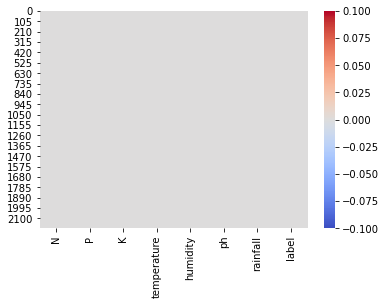

In [11]:
sns.heatmap(df.isnull(),cmap="coolwarm")
plt.show()

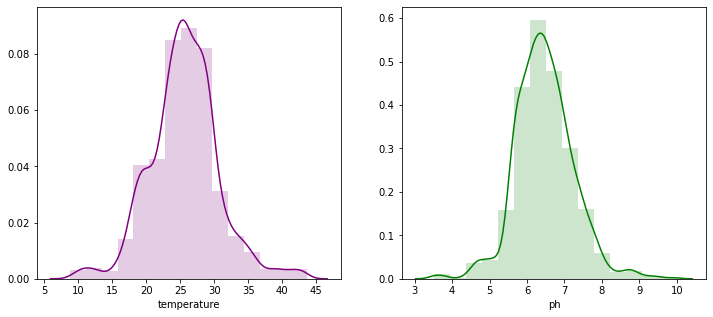

In [12]:
plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
# sns.distplot(df_setosa['sepal_length'],kde=True,color='green',bins=20,hist_kws={'alpha':0.3})
sns.distplot(df['temperature'],color="purple",bins=15,hist_kws={'alpha':0.2})
plt.subplot(1, 2, 2)
sns.distplot(df['ph'],color="green",bins=15,hist_kws={'alpha':0.2})

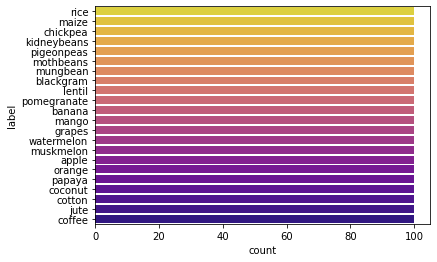

In [13]:
sns.countplot(y='label',data=df, palette="plasma_r")

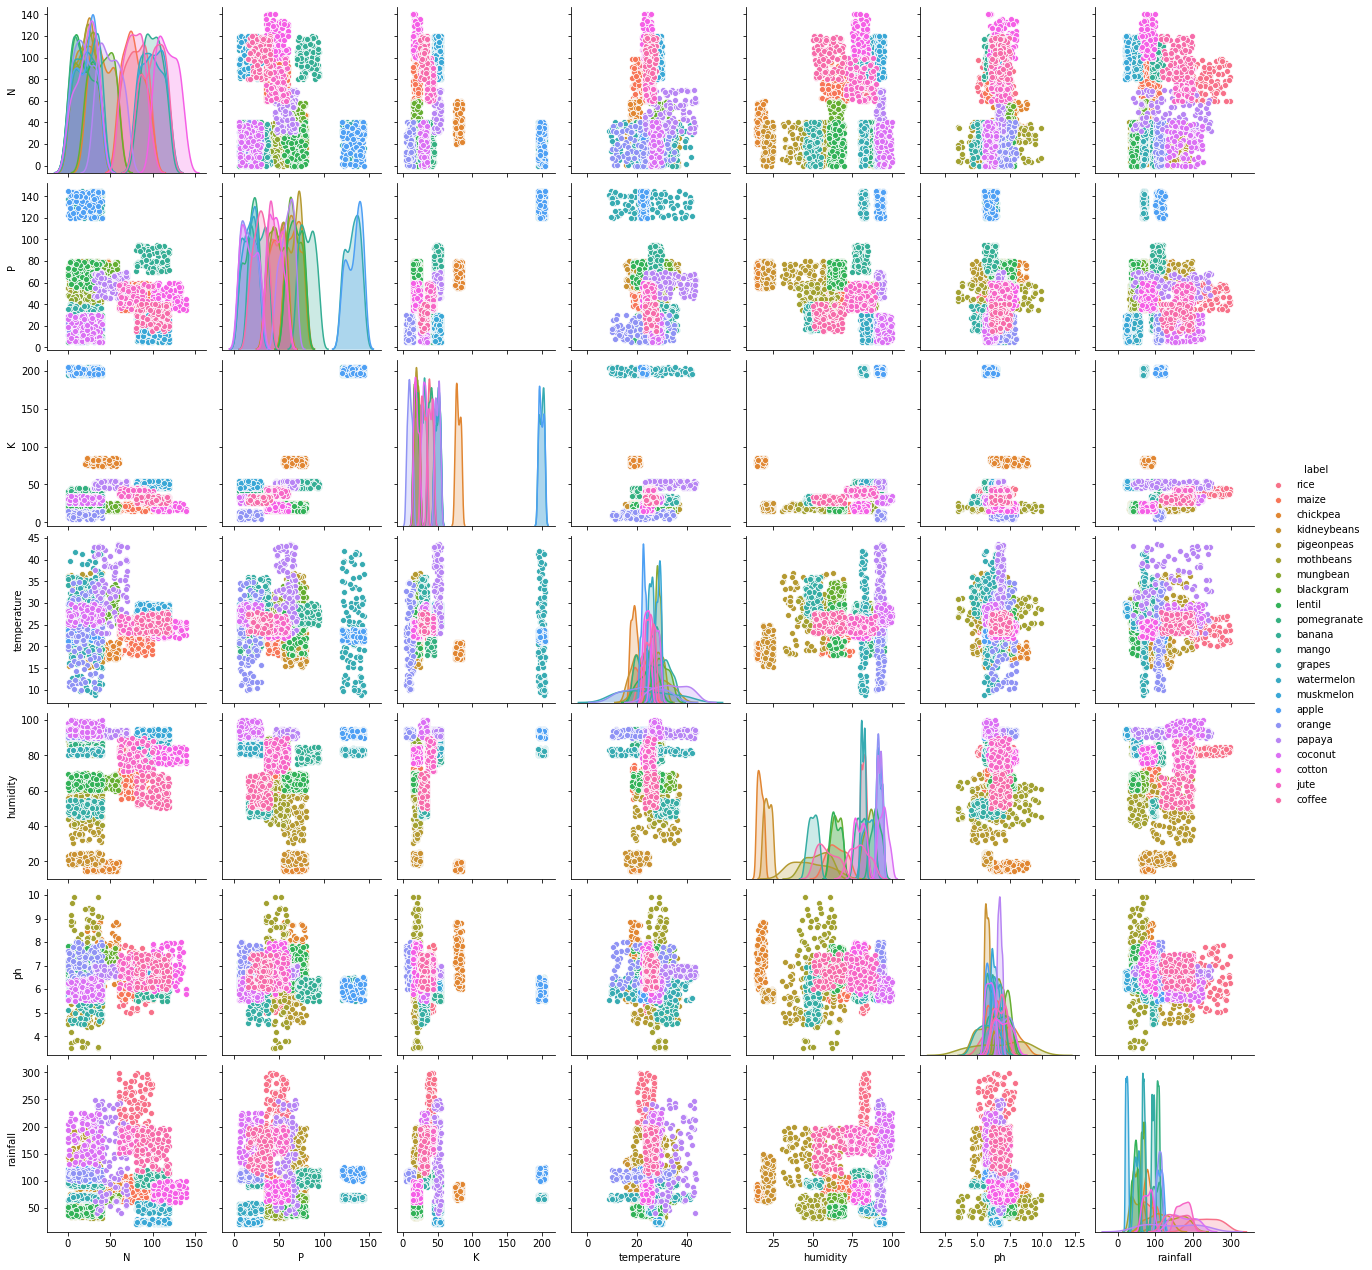

In [14]:
sns.pairplot(df, hue = 'label')

In [15]:
c=df.label.astype('category')
targets = dict(enumerate(c.cat.categories))
df['target']=c.cat.codes

y=df.target
X=df[['N','P','K','temperature','humidity','ph','rainfall']]

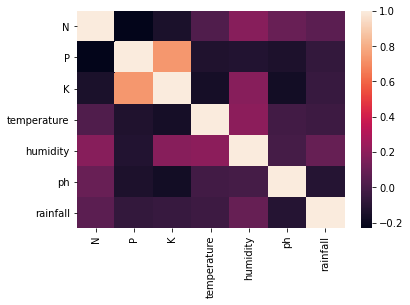

In [16]:
sns.heatmap(X.corr())

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=1)

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)

# we must apply the scaling to the test set as well that we are computing for the training set
X_test_scaled = scaler.transform(X_test)

In [18]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(X_train_scaled, y_train)
knn.score(X_test_scaled, y_test)

0.9781818181818182

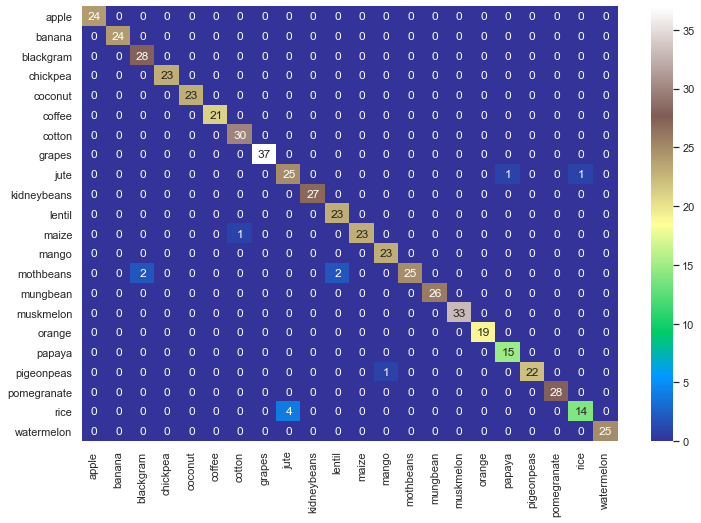

In [19]:
from sklearn.metrics import confusion_matrix
mat=confusion_matrix(y_test,knn.predict(X_test_scaled))
df_cm = pd.DataFrame(mat, list(targets.values()), list(targets.values()))
sns.set(font_scale=1.0) # for label size
plt.figure(figsize = (12,8))
sns.heatmap(df_cm, annot=True, annot_kws={"size": 12},cmap="terrain")

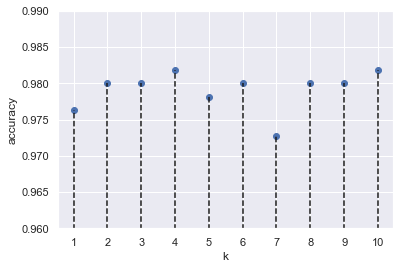

In [20]:
k_range = range(1,11)
scores = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train_scaled, y_train)
    scores.append(knn.score(X_test_scaled, y_test))

plt.xlabel('k')
plt.ylabel('accuracy')
plt.scatter(k_range, scores)
plt.vlines(k_range,0, scores, linestyle="dashed")
plt.ylim(0.96,0.99)
plt.xticks([i for i in range(1,11)]);

In [21]:
from sklearn.svm import SVC

svc_linear = SVC(kernel = 'linear').fit(X_train_scaled, y_train)
print("Linear Kernel Accuracy: ",svc_linear.score(X_test_scaled,y_test))

svc_poly = SVC(kernel = 'rbf').fit(X_train_scaled, y_train)
print("Rbf Kernel Accuracy: ", svc_poly.score(X_test_scaled,y_test))

svc_poly = SVC(kernel = 'poly').fit(X_train_scaled, y_train)
print("Poly Kernel Accuracy: ", svc_poly.score(X_test_scaled,y_test))

Linear Kernel Accuracy:  0.9745454545454545
Rbf Kernel Accuracy:  0.9872727272727273
Poly Kernel Accuracy:  0.9890909090909091


In [22]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

parameters = {'C': np.logspace(-3, 2, 6).tolist(), 'gamma': np.logspace(-3, 2, 6).tolist()}
# 'degree': np.arange(0,5,1).tolist(), 'kernel':['linear','rbf','poly']

model = GridSearchCV(estimator = SVC(kernel="linear"), param_grid=parameters, n_jobs=-1, cv=4)
model.fit(X_train, y_train)

GridSearchCV(cv=4, estimator=SVC(kernel='linear'), n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0],
                         'gamma': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]})

In [23]:
print(model.best_score_ )
print(model.best_params_ )

0.9866710547967747
{'C': 1.0, 'gamma': 0.001}


In [24]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(random_state=42).fit(X_train, y_train)
clf.score(X_test,y_test)

0.9872727272727273

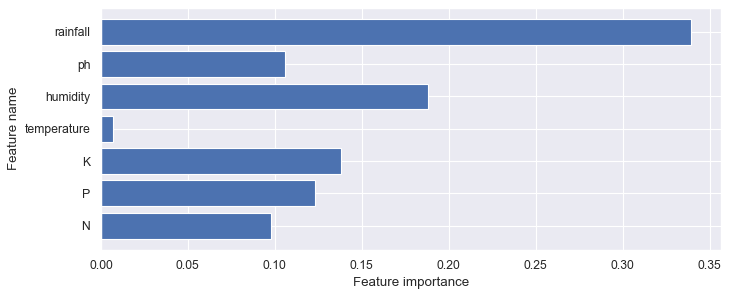

In [25]:
plt.figure(figsize=(10,4), dpi=80)
c_features = len(X_train.columns)
plt.barh(range(c_features), clf.feature_importances_)
plt.xlabel("Feature importance")
plt.ylabel("Feature name")
plt.yticks(np.arange(c_features), X_train.columns)
plt.show()

In [26]:
'''
max depth and n_estimator are important to fine tune otherwise trees will be densely graphed which will be a classic case of overfitting. max_depth=4 and n_estimators=10 gives pretty much satisfying results by making sure model is able to generalize well.
'''

from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth=4,n_estimators=100,random_state=42).fit(X_train, y_train)

print('RF Accuracy on training set: {:.2f}'.format(clf.score(X_train, y_train)))
print('RF Accuracy on test set: {:.2f}'.format(clf.score(X_test, y_test)))

RF Accuracy on training set: 0.97
RF Accuracy on test set: 0.97


In [27]:
from sklearn.ensemble import GradientBoostingClassifier
grad = GradientBoostingClassifier().fit(X_train, y_train)
print('Gradient Boosting accuracy : {}'.format(grad.score(X_test,y_test)))

Gradient Boosting accuracy : 0.9963636363636363


In [28]:
# save the model to disk
filename = 'model.sav'
pickle.dump(model, open(filename, 'wb'))
pickle.dump(knn,open('model.pkl','wb'))

In [35]:
# Define simple neural network model
# Keras

from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.optimizers import Adam,RMSprop
import tensorflow as tf

model = Sequential()
model.add(Dense(128, input_dim=7, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(22, activation='softmax'))

model.summary()


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 128)               1024      
_________________________________________________________________
dense_13 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_14 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_15 (Dense)             (None, 22)                1430      
Total params: 27,222
Trainable params: 27,222
Non-trainable params: 0
_________________________________________________________________


In [51]:
callback = tf.keras.callbacks.ModelCheckpoint(filepath='best_model.h5',
                                                  monitor='val_acc', mode='max',
                                                 verbose=1)

es = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

In [52]:
# Compile the Neural network
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# Fit to training data
model.fit(X_train, y_train, epochs=100, validation_data=(X_test,y_test),
                    callbacks=[callback , es])

Epoch 1/100
52/52 [==============================] - 1s 6ms/step - loss: 0.1396 - accuracy: 0.9479 - val_loss: 0.0886 - val_accuracy: 0.9600

Epoch 00001: saving model to best_model.h5
Epoch 2/100
52/52 [==============================] - 0s 3ms/step - loss: 0.1227 - accuracy: 0.9533 - val_loss: 0.0884 - val_accuracy: 0.9709

Epoch 00002: saving model to best_model.h5
Epoch 3/100
52/52 [==============================] - 0s 3ms/step - loss: 0.0828 - accuracy: 0.9667 - val_loss: 0.0762 - val_accuracy: 0.9818

Epoch 00003: saving model to best_model.h5
Epoch 4/100
52/52 [==============================] - 0s 2ms/step - loss: 0.0901 - accuracy: 0.9667 - val_loss: 0.0950 - val_accuracy: 0.9655

Epoch 00004: saving model to best_model.h5
Epoch 5/100
52/52 [==============================] - 0s 2ms/step - loss: 0.0986 - accuracy: 0.9630 - val_loss: 0.1036 - val_accuracy: 0.9691

Epoch 00005: saving model to best_model.h5
Epoch 6/100
52/52 [==============================] - 0s 3ms/step - loss: 0.

In [53]:
loss, acc = model.evaluate(X_test, y_test, verbose=2)

18/18 - 0s - loss: 0.0659 - accuracy: 0.9800


In [54]:
model.save("cropmodel.h5")
print("model saved")

model saved


In [55]:
targets.values()

dict_values(['apple', 'banana', 'blackgram', 'chickpea', 'coconut', 'coffee', 'cotton', 'grapes', 'jute', 'kidneybeans', 'lentil', 'maize', 'mango', 'mothbeans', 'mungbean', 'muskmelon', 'orange', 'papaya', 'pigeonpeas', 'pomegranate', 'rice', 'watermelon'])